# Case Study 5 (Part - II) DNN Classification (PyTorch) — Power Grid Disruption

**Goal:** predict `power_grid_disruption` (a discrete class label) from solar storm features.

Workflow:
1. Load data  
2. Drop ID/date columns  
3. One-hot encode the categorical feature (`solar_flare_class`)  
4. Min–max scale **all** features (numeric + one-hot)  
5. Train/test split (70% / 30%)  
6. Train a small DNN classifier  
7. Evaluate with **confusion matrix** and **classification report**


In [31]:
# =========================
# 0) Imports + setup
# =========================
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cpu'

## 1) Load data

Update `CSV_PATH` if needed.


In [32]:
# =========================
# 1) Load dataset
# =========================
CSV_PATH = "solar_storm_impact_dataset.csv"  # <-- change if needed
df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
df.head()


Shape: (1000, 9)


,event_id,event_date,solar_flare_class,flare_intensity,geomagnetic_index_Kp,solar_wind_speed,solar_wind_density,flare_duration_minutes,power_grid_disruption
0,1,2018-10-01,X,96.25,4,558.43,12.62,10,2
1,2,2020-09-28,M,31.15,0,723.17,6.26,95,1
2,3,2020-03-15,C,23.93,0,626.27,7.81,44,1
3,4,2008-01-11,M,62.66,2,498.49,5.94,136,1
4,5,2022-03-30,M,37.73,0,505.02,18.03,86,1


## 2) Keep only needed columns

We **remove**:
- `event_id` (identifier)
- `event_date` (date string)

We use:
- `solar_flare_class` (categorical: C/M/X) → one-hot encoding  
- Numeric features: `flare_intensity`, `geomagnetic_index_Kp`, `solar_wind_speed`, `solar_wind_density`, `flare_duration_minutes`  
- Target: `power_grid_disruption` (class label)


In [33]:
# =========================
# 2) Select columns
# =========================
DROP_COLS = ["event_id", "event_date"]

CAT_COL = "solar_flare_class"
NUM_COLS = [
    "flare_intensity",
    "geomagnetic_index_Kp",
    "solar_wind_speed",
    "solar_wind_density",
    "flare_duration_minutes",
]
TARGET = "power_grid_disruption"

df = df.drop(columns=DROP_COLS, errors="ignore")
df = df[[CAT_COL] + NUM_COLS + [TARGET]].copy()
df.head()


,solar_flare_class,flare_intensity,geomagnetic_index_Kp,solar_wind_speed,solar_wind_density,flare_duration_minutes,power_grid_disruption
0,X,96.25,4,558.43,12.62,10,2
1,M,31.15,0,723.17,6.26,95,1
2,C,23.93,0,626.27,7.81,44,1
3,M,62.66,2,498.49,5.94,136,1
4,M,37.73,0,505.02,18.03,86,1


## 3) Clean data (avoid NaNs)

We convert numeric columns to numbers and drop rows with missing values.


In [34]:
# =========================
# 3) Clean data
# =========================
df[NUM_COLS] = df[NUM_COLS].apply(pd.to_numeric, errors="coerce")
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce")

df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

print("Rows after cleaning:", len(df))
print(df.isna().sum())


Rows after cleaning: 1000
solar_flare_class         0
flare_intensity           0
geomagnetic_index_Kp      0
solar_wind_speed          0
solar_wind_density        0
flare_duration_minutes    0
power_grid_disruption     0
dtype: int64


## 4) Train/test split (70% / 30%)

We stratify by the target so both sets have similar class proportions.


In [35]:
# =========================
# 4) Split
# =========================
X_raw = df[[CAT_COL] + NUM_COLS]
y_raw = df[TARGET].astype(int).to_numpy()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.30, random_state=SEED, stratify=y_raw
)

print("Train:", X_train_raw.shape, y_train.shape)
print("Test :", X_test_raw.shape,  y_test.shape)
print("Train class counts:", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))


Train: (700, 6) (700,)
Test : (300, 6) (300,)
Train class counts: [289 317  94]
Test  class counts: [124 136  40]


## 5) One-hot encode + min–max scale (fit on train only)

- OneHotEncoder converts the categorical feature into 0/1 columns.  
- MinMaxScaler scales every feature into **[0, 1]**.

Fit on **train**, apply to **test**.


In [36]:
# =========================
# 5) Preprocess: OHE + MinMax scaling
# =========================
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
scaler = MinMaxScaler()

X_train_cat = ohe.fit_transform(X_train_raw[[CAT_COL]])
X_test_cat  = ohe.transform(X_test_raw[[CAT_COL]])

X_train_num = X_train_raw[NUM_COLS].to_numpy(np.float32)
X_test_num  = X_test_raw[NUM_COLS].to_numpy(np.float32)

# Combine: [one-hot | numeric] -> should be 3 + 5 = 8 features
X_train_all = np.hstack([X_train_cat, X_train_num]).astype(np.float32)
X_test_all  = np.hstack([X_test_cat,  X_test_num]).astype(np.float32)

X_train_s = scaler.fit_transform(X_train_all).astype(np.float32)
X_test_s  = scaler.transform(X_test_all).astype(np.float32)

print("One-hot categories:", ohe.categories_)
print("X_train shape after OHE+num:", X_train_all.shape)
print("Scaled range (min/max):", X_train_s.min(), X_train_s.max())


One-hot categories: [array(['C', 'M', 'X'], dtype=object)]
X_train shape after OHE+num: (700, 8)
Scaled range (min/max): 0.0 1.0


## 6) Torch DataLoaders

In [37]:
# =========================
# 6) Torch tensors + loaders
# =========================
Xtr = torch.tensor(X_train_s, dtype=torch.float32)
Xte = torch.tensor(X_test_s,  dtype=torch.float32)

ytr = torch.tensor(y_train, dtype=torch.long)  # class indices
yte = torch.tensor(y_test,  dtype=torch.long)

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)


## 7) Define the DNN classifier (8 → 6 → C)

- Hidden: **Linear → BatchNorm → ReLU → Dropout**  
- Output: **Linear with C logits** (one per class, no softmax)

**Note (PyTorch vs TensorFlow):**
- In **PyTorch**, `CrossEntropyLoss` expects **raw logits** (so **do not** put a `Softmax` layer inside your model). The loss applies the softmax internally in a numerically stable way.
- In **TensorFlow/Keras**, it’s common to explicitly set the **last-layer activation** (e.g., `softmax`) in the model definition **depending on how you configure the loss** (e.g., `from_logits=True/False`).


In [38]:
# =========================
# 7) Model: 8 -> 6 -> C  (with overfitting mitigation)
# =========================
NUM_CLASSES = int(np.unique(y_train).size)

class DNNClassifier(nn.Module):
    def __init__(self, in_dim=8, hidden_dim=6, num_classes=3, dropout_p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),      # <-- hidden layer (8 -> 6)
            nn.BatchNorm1d(hidden_dim),         # <-- batch norm (stability/regularization)
            nn.ReLU(),                          # <-- nonlinearity
            nn.Dropout(dropout_p),              # <-- dropout regularization
            nn.Linear(hidden_dim, num_classes)  # <-- output layer (6 -> C logits)
        )

    def forward(self, x):
        return self.net(x)

model = DNNClassifier(in_dim=X_train_s.shape[1], hidden_dim=6, num_classes=NUM_CLASSES, dropout_p=0.1).to(DEVICE)
model

DNNClassifier(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=6, bias=True)
    (1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=6, out_features=3, bias=True)
  )
)

## 8) Train the model

- Loss: **CrossEntropyLoss**  
- Optimizer: **Adam**
- Regularization: **L2** via `weight_decay`


In [39]:
# =========================
# 8) Training loop (with L2 regularization)
# =========================
def train(model, train_loader, epochs=2000, lr=1e-2, weight_decay=1e-4):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # <-- L2
    loss_fn = nn.CrossEntropyLoss()  # <-- classification loss

    for epoch in range(1, epochs + 1):
        losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            opt.zero_grad()
            logits = model(xb)  # <-- model outputs logits
            loss = loss_fn(logits, yb)  # <-- CrossEntropyLoss expects logits and class indices
            loss.backward()
            opt.step()

            losses.append(loss.item())

        if epoch in [1, 500, 1000, 1500, 2000]:
            print(f"Epoch {epoch:4d} | train loss (CrossEntropy): {np.mean(losses):.6f}")

train(model, train_loader, epochs=2000, lr=1e-2, weight_decay=1e-4)


Epoch    1 | train loss (CrossEntropy): 0.947668
Epoch  500 | train loss (CrossEntropy): 0.133496
Epoch 1000 | train loss (CrossEntropy): 0.134372
Epoch 1500 | train loss (CrossEntropy): 0.100336
Epoch 2000 | train loss (CrossEntropy): 0.131652


## 9) Evaluate (confusion matrix + classification report)


Classification report (test):
              precision    recall  f1-score   support

           0      0.992     0.992     0.992       124
           1      0.971     0.993     0.982       136
           2      1.000     0.925     0.961        40

    accuracy                          0.983       300
   macro avg      0.988     0.970     0.978       300
weighted avg      0.984     0.983     0.983       300



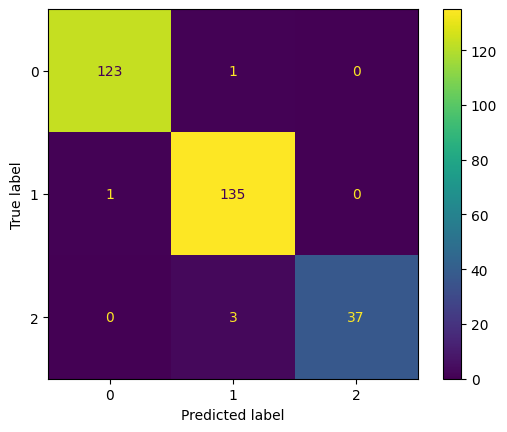

In [40]:
# =========================
# 9) Predict + evaluate on test set
# =========================
model.eval()
with torch.no_grad():
    logits_test = model(Xte.to(DEVICE)).cpu().numpy()

y_pred = logits_test.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred, labels=np.arange(NUM_CLASSES))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(NUM_CLASSES))
disp.plot(values_format="d")

print("\nClassification report (test):")
print(classification_report(y_test, y_pred, digits=3))


### Quick takeaways:
- One-hot encode categorical inputs  
- Min–max scale all features  
- Use `CrossEntropyLoss` for multi-class classification  
- Confusion matrix + classification report show what the model gets right/wrong  
